In [1]:
import tensorflow as tf

In [3]:
n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons], dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons, n_neurons], dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

In [7]:
import numpy as np

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [8]:
print(Y0_val)

[[ 0.6141028  -0.9834594   0.9389134  -0.3250603   0.8752752 ]
 [ 0.23645619 -1.          0.99998313  0.01051178  0.99848753]
 [-0.22929767 -1.          1.          0.34373274  0.9999828 ]
 [ 0.48407245 -0.9999998   0.9999497  -0.8641653   0.9989708 ]]


In [9]:
print(Y1_val)

[[-0.98760873 -1.          1.         -0.03640591  0.9999966 ]
 [-0.19279832 -0.40030646  0.99512845 -0.72622496  0.7911428 ]
 [-0.93416137 -1.          1.          0.6054483   0.99934417]
 [-0.99424994 -0.99999547  0.99994475 -0.8570875   0.9225749 ]]


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
import numpy as np
from scipy import signal

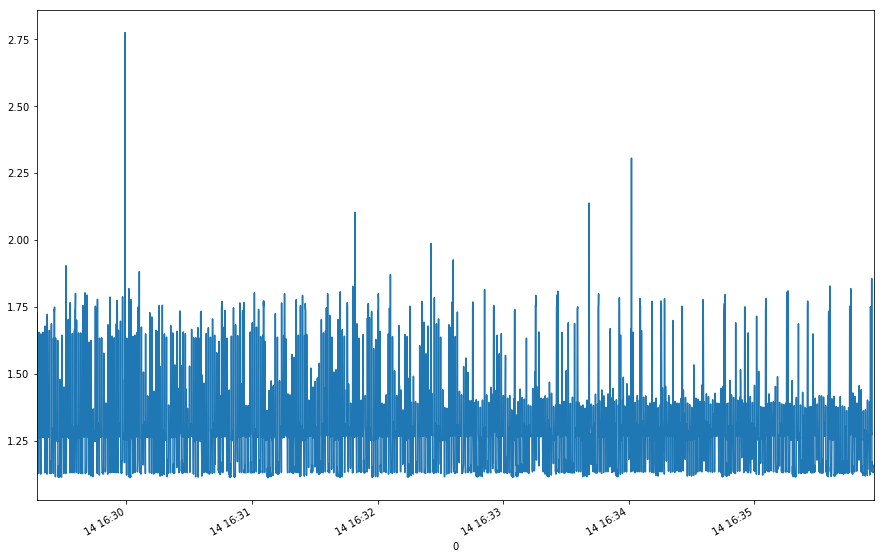

In [46]:
raw_data = pd.read_csv('../raw_data/20190214/piclean_3h.dat', delimiter=',', header=None)
ts = pd.Series(list(raw_data[1]), pd.to_datetime(raw_data[0], unit='ms', utc=True).dt.tz_convert('US/Eastern'))
seg = (ts[5000:9001])
seg.plot(figsize = (15, 10))

In [56]:
tf.reset_default_graph()

n_steps = 100
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [57]:
num_periods = 100

seg_data = np.array(seg)
train_len = int(len(seg_data)*0.8)
test_len = len(seg_data) - train_len
X_train = seg_data[:train_len-(train_len % num_periods)]
X_batch = X_train.reshape(-1, num_periods, 1)
y_train = seg_data[1:(train_len-(train_len % num_periods)) + 1]
y_batch = y_train.reshape(-1, num_periods, 1)
print(X_batch.shape, y_batch.shape)

X_test = seg_data[train_len-(train_len % num_periods):-1].reshape(-1, num_periods, 1)
y_test = seg_data[train_len-(train_len % num_periods)+1:].reshape(-1, num_periods, 1)
print(X_test.shape, y_test.shape)

(32, 100, 1) (32, 100, 1)
(8, 100, 1) (8, 100, 1)


In [58]:
n_iterations = 2000

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
            
    y_pred = sess.run(outputs, feed_dict={X: X_test})

0 	MSE: 2.1920445
100 	MSE: 0.03558686
200 	MSE: 0.024317484
300 	MSE: 0.012072398
400 	MSE: 0.009014237
500 	MSE: 0.008297231
600 	MSE: 0.007925386
700 	MSE: 0.0075115375
800 	MSE: 0.0075400947
900 	MSE: 0.0068917377
1000 	MSE: 0.006809001
1100 	MSE: 0.006745249
1200 	MSE: 0.0067464625
1300 	MSE: 0.0066549275
1400 	MSE: 0.006803415
1500 	MSE: 0.0058746696
1600 	MSE: 0.006553727
1700 	MSE: 0.005957025
1800 	MSE: 0.009326697
1900 	MSE: 0.006048159


In [54]:
y_pred_all = y_pred.reshape(-1,1)
y_test_all = y_test.reshape(-1,1)
y_err = (y_pred_all - y_test_all)
print("3 sigma = " + str(y_err.std() * 3))

3 sigma = 0.21294844193415174


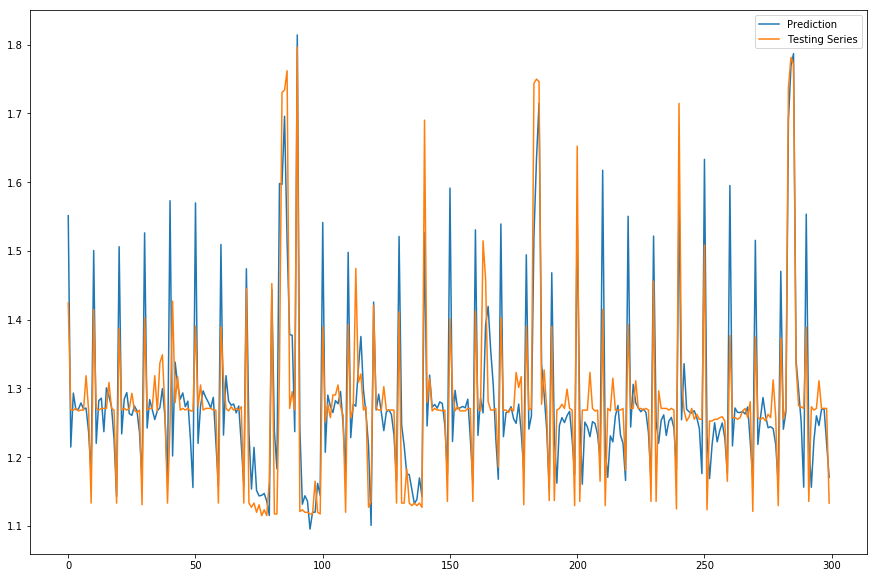

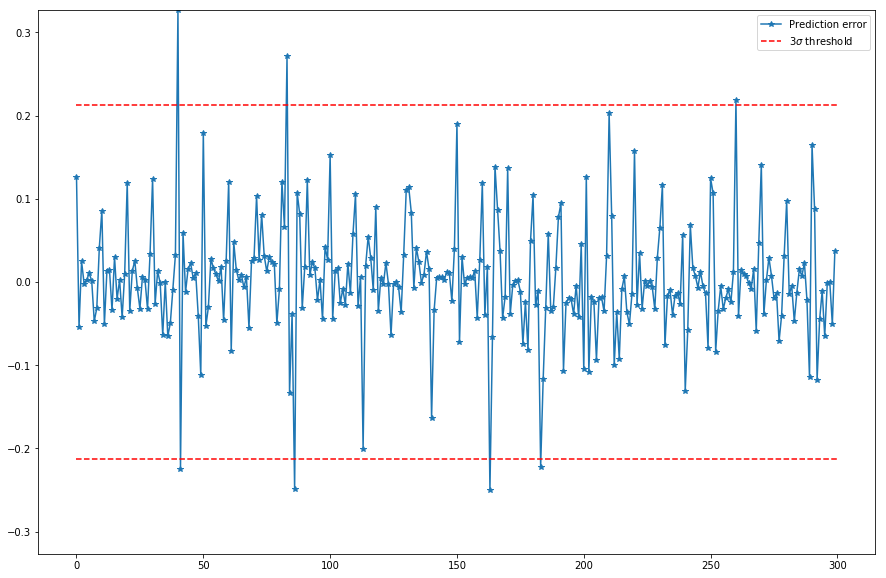

In [55]:
start = 0
end = 300
plt.figure(figsize=(15,10))
plt.plot(y_pred_all[start:end])
plt.plot(y_test_all[start:end])
plt.legend(['Prediction', 'Testing Series'])
plt.figure(figsize=(15,10))
plt.plot(y_err[start:end], '-*')
plt.plot([0, end-start], [y_err.std() * 3, y_err.std() * 3], 'r--')
plt.plot([0, end-start], [-y_err.std() * 3, -y_err.std() * 3], 'r--')
plt.ylim([-np.max(np.abs(y_err)), np.max(np.abs(y_err))])
plt.legend(['Prediction error', '3$\sigma$ threshold'])